In [1]:
%pip install --upgrade torchvision;
%pip install --upgrade datasets;
%pip install --upgrade h5py;
%pip install --upgrade kornia

In [2]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import json
import csv
import logging
from tqdm import tqdm
import torch
import datasets
from datasets.combine import *
import PIL
from collections import OrderedDict
import time
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from timm import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
from torchvision.transforms.v2 import functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kornia import filters
import kornia.augmentation as K


# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually


_URLS = {'root': os.curdir,'cache_dir':"raw"}
_BATCH_SIZE = 2
_NUM_WORKERS = 8
_TRAIN_SPLIT = {'d1':1,'d2':0,'d3':3, 'd4':4}
_VALID_SPLIT = '2'
_TEST_SPLIT = "chabud"
_INPUT_SIZE = 512
_PATCHES_SIDE = 3


Тут можна задати спліти 0-4, що дає вчитися і перевіряти метрики на незалежних вибірках



In [3]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])
sys.path.append(os.path.abspath('..'))

# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: ./raw


In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device)

In [5]:
# Load the CaBuAr dataset
# Possible splits: 0-4, or chabud
# For docs check out
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar
d1 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d1']}", trust_remote_code=True)
d2 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d2']}", trust_remote_code=True)
d3 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d3']}", trust_remote_code=True)
d4 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d4']}", trust_remote_code=True)
valid_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_VALID_SPLIT}',trust_remote_code=True).with_format("torch")
test_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TEST_SPLIT}',trust_remote_code=True).with_format("torch")

train_data = interleave_datasets([d1, d2, d3, d4], stopping_strategy='all_exhausted').with_format("torch")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### На основі аналізу датасету запроповані рішення для перетворення датасету
 - Create an class ratio graphic in output mask

Бінарність класів спрощує Segmentation loss в просту бінарну кроссентропію з логітами.
 Використаємо взваження класів відносно їх частоти в зображенні всередині  лосс функції за допомогою class_weights.
Додаємо до BCE лосс-функції додатково Dice loss, що є диферренційованим F1 score

 - Mean brightness, distribution per-channel of images

Додамо першим шаром батч нормалізацію,

**Створимо синтез фіч**:
1.  порахувавши індекс щільності рослинності (NDVI): гіперболічну дистанцію між яскравістю пікселів Червоного (B04), Інфрачервоного (B08) каналів першим каналом,
2. А також для Довгих інфрачервоних DWDM каналів B12 і B11.

3. Останнім каналом візьмемо B09, для відокремлення вологого грунту
від спаленої землі і водних об'єктів.

Присутність великого набору семплів з пустими масками (class 0) підвищує захищеність моделі

Для зменшення шуму окремо згладимо вхідне зображення з Гауссовим блюром

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

Так як не присутня залежність між зображеннями в батчі, регуляризація виконується для кожної пари вхідне зображення --- маска:

1. До вхідного зображення додається невелика кількість шуму

2. З RandomJigsaw синхронно розрізаємо зображення та маску на квадрати NxN і перемішуємо їх

3. Під час тренування для одночасно маски і зображення робимо афінне перетворення, відображаємо вертикально та горизонтально

Ціллю є підвищення інваріантності по переміщенню і обертанню, подальше використання dropout для зменшення глобальних глобальних активацій нейронів, і більшого фокусу моделі на локальних фічах, інваріантно від топографії ландшафту і присутніх на ньому географічних ознак.

# Preprocessing

- Hyperbolic difference

Відображає нелінійний ріст залежності, накладає вагу для збільшення контрасту між схожими значеннями і аутлаєрами, додає біас.

In [6]:
def hyperbolic_diff(img_x, img_y, scale = 0.5, bias = 0):
    if bias == -1e-6:
        bias = 0
    return scale * (img_x - img_y) / (img_x + img_y + bias + 1e-6)

Перетворення листків датасету в тензори toTensor замінено на torch.tensor()

- Transform виконується одночасно на вхідному зображенні і масці; стосується лише афінних перетворень без зміни кольорів

- Augmentation - лише для вхідного зображення post_fire - згладжує зображення для ідентифікації грубих фіч, видаляє частину інформації для підвищення робастності на реальному тестуванні

- Important to denoise the data,
 using gaussian blur pyramids

In [7]:
gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
adjust_contrast = transforms.ColorJitter(contrast=1.5)

transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomRotation(degrees=(80, 100))
    ]),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

augmentation = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])

- Define scripts to convert image to 3 channel image
- Define clipping of class values
-  Normalization
- Showing before/after
- Resizing of images, important for  (Optional)

## Three channels
- (Natural Density of Vegetation, Water vapor intensity, medium-long infrared ratio)

- Розділяємо батч на окремі зображення (3, 512, 512) і маску (1, 512, 512)

Видалені канали:

- B01 - рівень аерозолю

- B02, 03 - зелений і синій, видима неозброєним оком рослинність і водойми

- B05-07 - Класифікація рослинних культур

- B10 - Тип хмар

- Всі інші канали крім B04, B08, B09, B11, B12 дропаємо для зменшення зайвого об'єму інформації поданого на вхід, і використання претренованих ваг.

[більше про індекси](https://www.mathworks.com/help/images/spectral-indices.html)

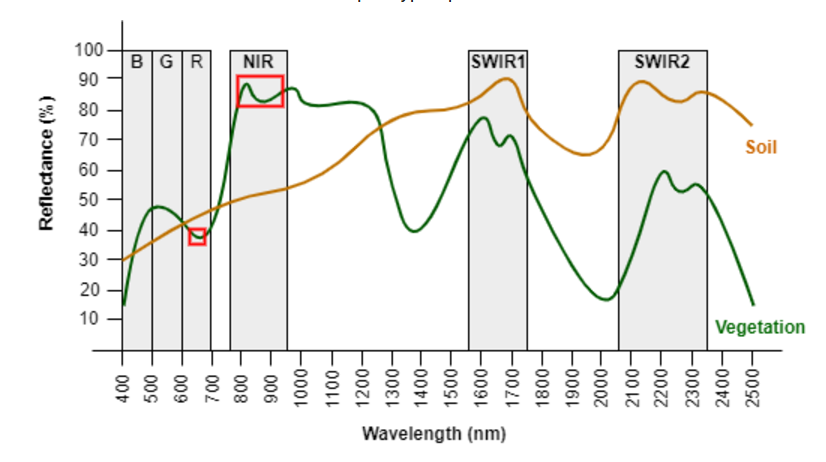

In [11]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        pre_nir = pre_fire[7, :, :]
        pre_red = pre_fire[3, :, :]
        post_nir = post_fire[7, :, :]
        post_red = post_fire[3, :, :]

        # Compute hyperbolic difference of channels
        ndvi_pre = hyperbolic_diff(pre_nir, pre_red, scale=8.5, bias=0.16)
        ndvi_post = hyperbolic_diff(post_nir, post_red, scale=8.5, bias=0.16)

        # Return a mean square distance between old and new
        return torch.square(ndvi_post - ndvi_pre)
        #return ndvi_post


    def fire_boundary(self, pre_fire, post_fire):
        # Extract low frequency bands:
        pre_band_11 = pre_fire[10, :, :]
        pre_band_12 = pre_fire[11, :, :]
        boundary_pre = hyperbolic_diff(pre_band_11, pre_band_12, 8.5, 0.5)

        post_band_11 = post_fire[10, :, :]
        post_band_12 = post_fire[11, :, :]
        boundary_post = hyperbolic_diff(post_band_11, post_band_12, 8.5, 0.5)  # Shape: [1, H, W]

        return torch.square(boundary_post - boundary_pre)

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']
        pre_fire = sample['pre_fire']
        mask = sample['mask']

        # Reshaping and retyping tensors
        post_fire = post_fire.to(torch.float).permute(2, 0, 1)
        pre_fire = pre_fire.to(torch.float).permute(2, 0, 1)
        mask = mask.to(torch.float).permute(2, 0, 1)

        # Calculate NDVI - natural vegetation index
        ndvi = self.calculate_ndvi(pre_fire, post_fire)

        # Compute fire boundary using sentinel script
        fire_boundary = self.fire_boundary(pre_fire, post_fire)

        # Extract water vapor band 09
        water_vapor = hyperbolic_diff(post_fire[8,:,:],pre_fire[8, :, :], scale=8.5)

        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi = self.augment(ndvi.unsqueeze(0))
            water_vapor = self.augment(water_vapor.unsqueeze(0))
            fire_boundary = self.augment(fire_boundary.unsqueeze(0))

        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.stack([ndvi.squeeze(), water_vapor.squeeze(), fire_boundary.squeeze(), mask.squeeze()], dim=0)  # 4 channels]

        # Transform all layers uniformly, to maintain ground truth on validation
        if self.transform:
            combined_input = self.transform(combined_input)

        # Prepare the X_input and y
        return combined_input[:-1], torch.round(combined_input[-1].unsqueeze(0))

Обгортка для передачі даних на CUDA

In [31]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

Train, validation і test лоадери

In [13]:

# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDataset(
    hf_dataset=train_data,
    transform=transform,
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDataset(
    hf_dataset=valid_data,
)
test_dataset = CaBuArPyTorchDataset(
    hf_dataset=test_data,
)

tr_loader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
vd_loader = WrappedDataLoader(DataLoader(
    valid_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
test_loader = WrappedDataLoader(DataLoader(
    test_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
print(f"train: {len(train_dataset)}")
print(f"valid: {len(valid_dataset)}")
print(f"test: {len(test_dataset)}")

train: 340
valid: 69
test: 68


Перевірка на доступність до завантаження файлів датасету

In [12]:
# %%time
# # Example: Iterate through the DataLoader
# for batch_idx, batch in enumerate(tr_loader):
#     X, y = batch

#     # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
#     # Example:
#     # outputs = model(post_fire, pre_fire)
#     # loss = criterion(outputs, mask)

#     # For demonstration, we'll just print the batch shapes
#     print(f"Batch {batch_idx}:")
#     print(f"  post_fire shape: {X.shape}")
#     print(f"  mask shape: {y.shape}")

#     # Break after first batch for demonstration
#     if batch_idx == 0:
#         break

### Відображення результатів препроцессингу

- Виділимо 5 випадкових зображень з train і test спліту

- Train додає трансформації до зображення

- Test показує оригінал без перетворень

### Зауваження

- В датасеті присутні як денні зображення, так і нічні. NDVI індекс виділяється добре лише на денних зображеннях.

In [13]:
# idx, processed_img = next(enumerate(tr_loader))

In [8]:

# Let's plot some images
def draw_transforms(batch_img, batch_size, ch, caption:str):
  x, y = batch_img
  fig, axes = plt.subplots(batch_size // 2, 2, figsize=(15,8))
  fig.suptitle(f"{caption}  channel {ch}", fontsize=20)
  im_pos = 0
  for i in range(batch_size):
      axes[im_pos % 2].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      im_pos += 1
      axes[im_pos % 2].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      axes[im_pos % 2].imshow(y[i].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy(), cmap='jet', alpha=0.5)
      im_pos += 1
  plt.show()


In [ ]:
# draw_transforms(processed_img, _BATCH_SIZE, 1, "train")

In [15]:
# idx, test_img = next(enumerate(test_loader))

In [16]:
# draw_transforms(test_img, _BATCH_SIZE, 0, "test")

## Використовуємо за Loss Combined BCE + F1 (Dice loss)

## Метрики - попіксельно F1/AuC та Extended IoU

Покращений IoU враховує відстань між масками і ground truth навіть за нульового перекриття, уникає плато нульового градієнту.

In [9]:
def write_results(results_file, results, format='csv'):
    with open(results_file, mode='w') as cf:
        if format == 'json':
            json.dump(results, cf, indent=4)
        else:
            if not isinstance(results, (list, tuple)):
                results = [results]
            if not results:
                return
            dw = csv.DictWriter(cf, fieldnames=results[0].keys())
            dw.writeheader()
            for r in results:
                dw.writerow(r)
            cf.flush()

def get_outfile(path, *paths, inc=False):
    outfile = os.path.join(path, *paths)
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    return outfile

def update_summary(epoch, train_metrics, eval_metrics, filename, write_header=False, log_wandb=False):
    rowd = OrderedDict(epoch=epoch)
    rowd.update([('train_' + k, v) for k, v in train_metrics.items()])
    rowd.update([('eval_' + k, v) for k, v in eval_metrics.items()])
    # if log_wandb:
    #     wandb.log(rowd)
    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        if write_header:  # first iteration (epoch == 1 can't be used)
            dw.writeheader()
        dw.writerow(rowd)

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.sigmoid(inputs)

        bce = torch.nn.functional.binary_cross_entropy(inputs, targets, weight=weights, reduction='mean')

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)


        return bce + dice_loss

### Не використовується як лосс, а як метрика для порівняння результатів

In [12]:
class Dice(nn.Module):
    def __init__(self, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return dice_score

In [11]:
class IoU(nn.Module):
    def __init__(self, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return IoU

### Додамо ваги класів в лосс для урахування дизбалансу.

In [13]:
total = 512*512*len(train_data)
positive_class = torch.sum(train_data["mask"].to(torch.int))
negative_class = total - positive_class
class_weights = torch.tensor([total / 2 / negative_class, total / 2 / positive_class]).to(device)

In [14]:
### Class imbalance (sometimes a few pixels against a backdrop of a single class)
### Should be solved by applying weight for error on each class by its size

def class_weights_mapping(y):
    return class_weights[y.to(torch.int)]

# Пайплайн тренування і валідації

In [15]:
def loss(model,
         loss_func,
         X, y,
         weights=None,
         optimizer=None
):
    loss_ = loss_func(model(X), y, weights)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), X.size(0)

In [16]:
iou_metric = IoU()
f1_metric = Dice()
def validate(
        model,
        loader,
        loss_fn,
        device=torch.device('cuda'),
        log_suffix='',
        log_frequency=10
):
    batch_time_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()
    f1_m = utils.AverageMeter()
    iou_m = utils.AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = loss_fn.forward(output, target)
            pred = torch.round(output)
            f1 = f1_metric(pred, target)
            iou = iou_metric(pred, target)

            losses_m.update(loss, input.size(0))
            f1_m.update(f1, input.size(0))
            iou_m.update(iou, input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()

    return losses_m.avg, f1_m.avg, iou_m.avg

In [17]:
def fit(epochs,
        batch_size,
        model,
        loss_func,
        optimizer,
        train_loader,
        valid_loader,
        lr_scheduler,
        patience=20,
        log_file=None
):
    history = []

    wait = 0
    val_loss_min = torch.inf
    train_loss = utils.AverageMeter()

    for epoch in tqdm(range(epochs)):
        train_loss.reset()
        model.train()
        running_loss = 0.
        losses = []
        for X, y in train_loader:
          weight = class_weights_mapping(y)
          train_loss.update(*loss(model, loss_func, X, y, weight, optimizer))

        if lr_scheduler is not None:
            lr_scheduler.step()

        val_loss, val_f1, val_iou = validate(model, valid_loader, loss_func, device)

        print(f"\nepoch: {epoch+1:3}, loss: {train_loss.avg:.5f}, valid loss: {val_loss:.5f}, valid F1 score: {val_f1:.3f}, valid IoU: {val_iou:.3f}")

        history.append((train_loss.avg, val_loss.item(), val_f1.item(), val_iou.item()))


        #TODO
        if log_file is not None:
          update_summary(epoch, {"loss": train_loss.avg}, {"loss": val_loss, "f1": val_f1, "iou":val_iou},
                    filename=f"{log_file}", write_header=new_file)
          new_file = False
            # Save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(f"Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(model.state_dict(), "model.pt")
            val_loss_min = val_loss
            wait = 0
        # Early stopping
        else:
            wait += 1
            if wait >= patience:
                print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                return history

    return history

In [139]:
def train(model, criterion, metric, optimizer, n_epochs,
          batch=64, saving_model_path=None, lr_scheduler=None):
    train_dataset = CaBuArPyTorchDatasetPlus(
        hf_dataset=train_data,
        transform=transform,
        augment=augmentation,
    )
    valid_dataset = CaBuArPyTorchDatasetPlus(
        hf_dataset=valid_data,
    )
    test_dataset = CaBuArPyTorchDatasetPlus(
        hf_dataset=test_data,
    )

    train_loader = WrappedDataLoader(DataLoader(
        train_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=True,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)
    valid_loader = WrappedDataLoader(DataLoader(
        valid_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=False,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)
    test_loader = WrappedDataLoader(DataLoader(
        test_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=False,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)

    print("\nFitting nn model")
    start_time = time.time()

    history = fit(n_epochs, batch, model.to(device), criterion, optimizer, train_loader, valid_loader, lr_scheduler)
    t = time.time() - start_time
    print(f'Fit time: {t} s')

    check_point = torch.load("model.pt", map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_f1, test_iou = validate(model, test_loader, criterion, device=device)

    if saving_model_path is not None:
        print("Saving model")
        torch.save(model.state_dict(), get_outfile(saving_model_path))
        update_summary("test", {}, {"loss": test_loss, "f1": test_f1, "iou":test_iou},
                       filename=f"{saving_model_path}")

    print(f"Test loss: {test_loss:.5f}, test F1 score: {test_f1:.3f}, test IoU: {test_iou:.3f}")
    return history

In [19]:
def plot_history(history):
    x = range(1, len(history)+1)
    train_loss, val_loss, f1_score, iou = zip(*history)
    fig, ax = plt.subplots(3, 1, figsize=(12, 15))

    ax[0].plot(x, train_loss, label="train")
    ax[0].plot(x, val_loss, label="val")
    ax[0].set_xticks(x)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Train and validation losses")

    ax[1].plot(x, f1_score)
    ax[1].set_xticks(x)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylim(0, 1)
    ax[1].set_ylabel("F1")
    ax[1].set_title("Validation F1 score")

    ax[2].plot(x, iou)
    ax[2].set_xticks(x)
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylim(0, 1)
    ax[2].set_ylabel("IoU")
    ax[2].set_title("Validation IoU")

    plt.show()

In [20]:
def display_results(results, top_k, metric_key, title):

    fig, axs = plt.subplots(3, top_k, figsize=(15, 8))
    for i, result in enumerate(results):
        # Image normalize
        input_img = (result['input'] - result['input'].min()) / (result['input'].max() - result['input'].min())

        # input
        axs[0, i].imshow(input_img.permute(1, 2, 0).numpy())
        axs[0, i].set_title(f"Input\n{metric_key.capitalize()}: {result[metric_key]:.4f}")
        axs[0, i].axis('off')

        # target
        axs[1, i].imshow(result['target'].squeeze().numpy(), cmap='gray')
        axs[1, i].set_title(f"Target\nLoss: {result['loss']:.4f}")
        axs[1, i].axis('off')

        # prediction
        prediction = (result['prediction'] - result['prediction'].min()) / (result['prediction'].max() - result['prediction'].min())
        axs[2, i].imshow(prediction.squeeze(), cmap='gray')
        axs[2, i].set_title("Prediction")
        axs[2, i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def sort_and_display_results(model, loader, loss_fn, top_k=5, metric_key='f1'):
    model.eval()
    results = []
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = loss_fn.forward(output, target)
            pred = torch.round(output)
            f1 = f1_metric(pred, target)
            iou = iou_metric(pred, target)

            for i in range(input.size(0)):
                        results.append({
                            'input': input[i].cpu(),
                            'target': target[i].cpu(),
                            'prediction': output[i].cpu(),
                            'loss': loss.item(),
                            'f1': f1.item(),
                            'iou': iou.item()
                        })


    if not all(metric_key in result for result in results):
        raise KeyError(f"Key '{metric_key}' not found in results.")

    # choose sort option
    is_loss = metric_key == 'loss'
    reverse_best = not is_loss
    reverse_worst = is_loss

    # sorted result
    sorted_results_best = sorted(results, key=lambda x: x[metric_key], reverse=reverse_best)[:top_k]
    sorted_results_worst = sorted(results, key=lambda x: x[metric_key], reverse=reverse_worst)[:top_k]

    # show best and worst by metrik and loss
    display_results(sorted_results_best, top_k, metric_key, title=f"Top {top_k} Best by {metric_key}")
    display_results(sorted_results_worst, top_k, metric_key, title=f"Top {top_k} Worst by {metric_key}")

    return results
# loss_avg, iou_avg, results = validate(fcn_model, vd_loader, criterion, device=device)

# sort_and_display_results(results, top_k=5, metric_key='metric')
# sort_and_display_results(results, top_k=5, metric_key='loss')


# Building FCN

## Model

In [21]:
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights

weight = FCN_ResNet101_Weights.DEFAULT
fcn_base_model = fcn_resnet101(weights=weight).to(device)

In [22]:
class FCN_Model(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.backbone = feature_extractor
        self.head_out = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )
        self.head_aux = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = features["out"]
        aux = features["aux"]
        res = self.head_out(out) + self.head_aux(aux)
        return res

In [23]:
fcn_model = FCN_Model(fcn_base_model.backbone, num_classes=1).to(device)

## Train

In [24]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-5, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.3)

In [ ]:
history = train(
    fcn_model,
    criterion,
    metric,
    optimizer,
    100,
    batch=_BATCH_SIZE,
    saving_model_path="model/fcn_model.pt",
    lr_scheduler=lr_scheduler
)

In [ ]:
plot_history(history)

# Building U-Net

## Model

In [25]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [26]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [27]:
unet_model = UNet(3, 1).to(device)

In [ ]:
check_point = torch.load("unet_model.pt", map_location=torch.device('cpu'))
unet_model.load_state_dict(check_point)

In [ ]:
sort_and_display_results(unet_model, test_loader, criterion, top_k=5, metric_key='loss')

## Train

In [32]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

NameError: name 'unet_model' is not defined

In [ ]:
history = train(
    unet_model,
    criterion,
    metric,
    optimizer,
    100,
    batch=_BATCH_SIZE,
    saving_model_path="model/unet_model.pt",
    lr_scheduler=lr_scheduler
)

In [ ]:
plot_history(history)

## Додамо більше інформації до датасету

- F1 Score = 0.4 для U-Net нижчий за baseline 0.7


In [129]:
# Make this dataset have better indexes
class CaBuArPyTorchDatasetPlus(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, img):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        nir = img[7, :, :]
        red = img[3, :, :]

        # Compute hyperbolic difference of channels:
        ndvi = hyperbolic_diff(nir, red, scale=1., bias=0.16)

        return ndvi

    # Compute Normalized burn ratio (NBR)
    def fire_boundary(self, img):
        # Extract low frequency bands:
        band_nri = img[7, :, :]
        band_swir = img[11, :, :]
        boundary = hyperbolic_diff(band_nri, band_swir, scale=1.) # Shape: [1, H, W]

        # post_band_nri = post_fire[7, :, :]
        # post_band_swir = post_fire[11, :, :]
        # boundary_post = hyperbolic_diff(post_band_11, post_band_12, scale=1.)

        # return torch.square(boundary_pre - boundary_post)
        return boundary

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']
        pre_fire = sample['pre_fire']
        mask = sample['mask']

        # Reshaping and retyping tensors
        post_fire = post_fire.to(torch.float).permute(2, 0, 1)
        pre_fire = pre_fire.to(torch.float).permute(2, 0, 1)
        mask = mask.to(torch.float).permute(2, 0, 1)

        # Calculate NDVI - natural vegetation index
        ndvi_pre = self.calculate_ndvi(pre_fire)
        ndvi_post = self.calculate_ndvi(post_fire)

        # Compute fire boundary using sentinel script

        fire_boundary_pre = self.fire_boundary(pre_fire)
        fire_boundary_post = self.fire_boundary(post_fire)
        print(f"Index shape: {fire_boundary_post.shape}\n")
        # Extract water vapor band 09
        # water_vapor = post_fire[8,:,:]
        upper_pre = F.normalize(pre_fire[1:9,:,:],
                                mean=[900., 1000., 1100., 1300., 2000.,2300., 2400., 2600.],
                                std=[150., 150., 200., 400., 500., 500., 600., 700.])

        upper_post = F.normalize(post_fire[1:9,:,:],
                                 mean=[900., 1000., 1100., 1300., 2000.,2300., 2400., 2600.],
                                std=[150., 150., 200., 400., 500., 500., 600., 700.])
        print(f"Other layers shape: {upper_pre.shape}\n")
        swir_pre = F.normalize(pre_fire[10:,:,:],
                               mean=[1550., 1000.], std=[1500., 900.])

        swir_post = F.normalize(post_fire[10:,:,:],
                               mean=[1550., 1000.], std=[1500., 900.])
        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi_pre = self.augment(ndvi_pre.unsqueeze(0))
            ndvi_post = self.augment(ndvi_post.unsqueeze(0))
            fire_boundary_pre = self.augment(fire_boundary_pre.unsqueeze(0))
            fire_boundary_post = self.augment(fire_boundary_post.unsqueeze(0))
            # water_vapor = self.augment(water_vapor.unsqueeze(0))
            upper_pre = self.augment(upper_pre)

            upper_post = self.augment(upper_post)
            print(f"Other layers shape: {upper_pre.shape}\n")
            swir_pre = self.augment(swir_pre)

            swir_post = self.augment(swir_post)

        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.cat([ndvi_pre, fire_boundary_pre, upper_pre, swir_pre,
                                      ndvi_post, fire_boundary_post, upper_post, swir_post,
                                      mask], dim=0)  # 26 channels]

        # Transform all layers uniformly, to maintain ground truth on validation
        if self.transform:
            combined_input = self.transform(combined_input)

            print(f"done for {idx}, Total shape: {upper_pre.shape}\n")
        # Prepare the X_input and y
        return combined_input[:-1], torch.round(combined_input[-1].unsqueeze(0))

In [130]:
# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDatasetPlus(
    hf_dataset=train_data,
    transform=transform,
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDatasetPlus(
    hf_dataset=valid_data,
)
test_dataset = CaBuArPyTorchDatasetPlus(
    hf_dataset=test_data,
)

tr_loader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
vd_loader = WrappedDataLoader(DataLoader(
    valid_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
test_loader = WrappedDataLoader(DataLoader(
    test_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

In [131]:
train_img = next(iter(tr_loader))

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])
Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])


Index shape: torch.Size([512, 512])
Other layers shape: torch.Size([8, 512, 512])


Other layers shape: torch.Size([8, 512, 512])
Other layers shape: torch.Size([8, 512, 512])


Other layers shape: torch.Size([8, 512, 512])
Index shape: torch.Size([512, 512])


Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])
Other layers shape: torch.Size([8, 512, 512])
Other layers shape: torch.Size([8, 512, 512])



Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])


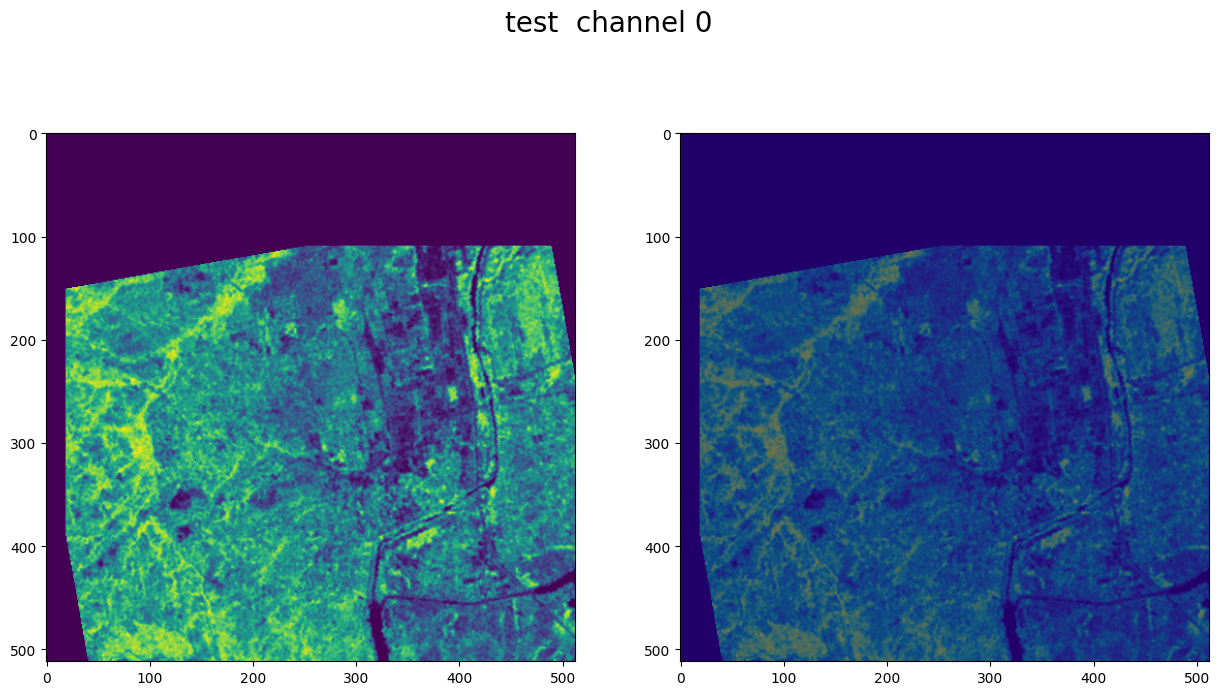

In [136]:
draw_transforms(train_img, _BATCH_SIZE, 0, "test")

In [142]:
x, y = train_img
print(x.shape)

torch.Size([2, 24, 512, 512])


In [143]:
unet_model_plus = UNet(24, 1)

In [138]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-5, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.3)

In [ ]:
history = train(
    unet_model_plus,
    criterion,
    metric,
    optimizer,
    1,
    batch=_BATCH_SIZE,
    saving_model_path="model/fcn_model.pt",
    lr_scheduler=lr_scheduler
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Fitting nn model


  0%|          | 0/1 [00:00<?, ?it/s]

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])

Other layers shape: torch.Size([8, 512, 512])

Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])

Other layers shape: torch.Size([8, 512, 512])
Other layers shape: torch.Size([8, 512, 512])


Index shape: torch.Size([512, 512])

Index shape: torch.Size([512, 512])
Other layers shape: torch.Size([8, 512, 512])

Index shape: torch.Size([512, 512])


Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])
Other layers shape: torch.Size([8, 512, 512])


Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])

Other layers shape: torch.Size([8, 512, 512])


In [ ]:
plot_history(history)

### Visualizing gradient changes from fire class

### Using GradCAM

- Let's flatten the nested model layer structure for easy access

In [33]:
def module2traced(module, inputs):
    handles, modules = [], []

    def trace(module, inputs, outputs):
        modules.append(module)

    def traverse(module):
        for m in module.children():
            traverse(m)  # recursion is love
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))

    traverse(module)

    _ = module(inputs)

    [h.remove() for h in handles]

    return modules

In [58]:
def relu_backward_deconv_hook(module, grad_input, grad_output):
    return torch.nn.functional.relu(grad_output[0]),

def equip_model_deconv(model):
    for m in model.modules():
        if isinstance(m, nn.ReLU):
            m.register_backward_hook(relu_backward_deconv_hook)

def hook_store_A(module, input, output):
    module.A = output[0]
def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

In [40]:
input_t, y = next(iter(test_loader))
check_point = torch.load("fcn_model.pt", map_location=torch.device('cpu'))
fcn_model.load_state_dict(check_point)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-40-b42fbf82bf13>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary o

<All keys matched successfully>

In [42]:
traced_fcn = module2traced(fcn_model, input_t)

In [62]:
def free(modules):
    for m in modules:
        del m
    torch.cuda.empty_cache()

In [ ]:
free(traced_fcn)

In [45]:
input_t.requires_grad_()
output_t = fcn_model(input_t)


RuntimeError: grad can be implicitly created only for scalar outputs

In [55]:
grad_input = torch.autograd.grad(output_t[0], output_t)

RuntimeError: grad can be implicitly created only for scalar outputs

In [47]:
print(traced_fcn)
print(len(traced_fcn))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), BatchNorm2d(64, eps=1e-0

In [59]:
# model = torchvision.models.vgg19(pretrained = True)
fcn_model.eval()
layer = traced_fcn[-4] # Last ReLU of the conv layers
layer.register_forward_hook(hook_store_A)
layer.register_backward_hook(hook_store_dydA)


In [60]:
def grad_view(model, idx):
    to_tensor = transforms.ToTensor()
    img = to_tensor(input_t[0])
    img = 0.5 + 0.5 * (img - img.mean()) / img.std()
    model.to(device)
    img = img.to(device)
    input = img.view(1, img.size(0), img.size(1), img.size(2)).requires_grad_()
    output = model(input)
    result = torch.autograd.grad(output.max(), input)
    result = result / result.max() + 0.5
    return result
# model = torchvision.models.vgg16(pretrained = True)
# model.eval()
# model = model.features
equip_model_deconv(fcn_model)
result = grad_view(fcn_model, 13)
utils.save_image(result, 'post-pre-fire-resnet-deconv.png')


AttributeError: module 'torchvision.transforms.v2.functional' has no attribute 'relu'

In [ ]:
def heatmap(model, input, target_class, target_layer):
  input = input.unsqueeze(0)
  output = model(input)
  target = output[0, target_class, :, :].mean()

  with model.zero_grad():
    target.backward()


    alpha = target_layer.dydA.mean((2,3), keepdim=True)
    L = torch.relu((alpha*target_layer.A).sum(1, keepdim=True))

    L = F.interpolate(L, size=(input.size(2), input.size(3)), mode='bilinear',
                         align_corners=False)
    # Extract heatmap from the torch compute graph, disable gradient computation
    L = L.squeeze().cpu().detach().numpy()

    # normalize
    L = torch.sigmoid(L)
    L = (L - L.min())/ (L.max() - L)